<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۰) وارد کردن کتابخانه‌های مورد نیاز
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در این نوتبوک هدف ما آموزش و تنظیم (Tuning) مدل <b>Random Forest</b> است.  
رندوم‌فارست یک مدل مبتنی بر درخت است که با ساخت چندین درخت و تجمیع نتایج آن‌ها، معمولاً دقت و پایداری بالایی به دست می‌دهد.
<br><br>
مزیت مهم Random Forest این است که برخلاف مدل‌های مبتنی بر فاصله (مثل KNN)، معمولاً به نرمال‌سازی ویژگی‌ها حساس نیست و بدون Scaling هم عملکرد خوبی دارد.
</font>
</p>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۱) خواندن داده‌های پیش‌پردازش‌شده
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
در نوتبوک پیش‌پردازش، داده‌ها پاکسازی و مهندسی ویژگی شده و در فایل ذخیره شده‌اند.  
در این نوتبوک تمرکز ما فقط روی مدل‌سازی Random Forest است؛ بنابراین داده‌های آماده را از فایل می‌خوانیم تا ساختار پروژه مرتب و ماژولار باشد.
</font>
</p>


In [2]:
train_data = pd.read_csv("../../data/train_processed.csv")

train_data.head()


,ReserveStatus,Male,Price,From,To,Domestic,VehicleClass,TripReason,Cancel,TicketPerOrder,family,Departure_Created,DepartureMonth,Bus,InternationalPlane,Plane,Train,Discount
0,5,True,6565575.0,217.0,80.0,1,0.0,1,0,3,False,10,11,False,False,True,False,True
1,5,True,9500000.0,171.0,80.0,1,0.0,0,0,2,True,2,8,False,False,True,False,False
2,3,False,2000000.0,135.0,37.0,1,1.0,1,0,3,False,0,9,True,False,False,False,False
3,2,False,40000.0,64.0,85.0,1,1.0,0,0,6,True,0,6,False,False,False,True,False
4,3,True,1130000.0,68.0,244.0,1,1.0,0,0,1,False,1,6,True,False,False,False,False


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۲) جدا کردن ویژگی‌ها (X) و متغیر هدف (y)
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای آموزش مدل، ستون هدف <code>TripReason</code> را به عنوان <b>y</b> جدا می‌کنیم و باقی ستون‌ها را به عنوان ویژگی‌های ورودی <b>X</b> در نظر می‌گیریم.  
این مرحله از وارد شدن ناخواسته ستون هدف به ورودی مدل جلوگیری می‌کند و ساختار مدل‌سازی را شفاف می‌سازد.
</font>
</p>
 

In [3]:
X = train_data.drop(columns=["TripReason"])
y = train_data["TripReason"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_val.shape)


(80304, 17) (20076, 17)


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۳) تقسیم داده به Train و Validation
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای ارزیابی واقعی عملکرد مدل، بخشی از داده را به عنوان مجموعه اعتبارسنجی کنار می‌گذاریم.  
همچنین از <code>stratify</code> استفاده می‌کنیم تا نسبت کلاس‌های TripReason در هر دو بخش مشابه باقی بماند و ارزیابی منصفانه‌تر شود.
</font>
</p>


In [4]:
f1_macro = make_scorer(f1_score, average="macro")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۴) نکته مهم: عدم نیاز Random Forest به Scaling
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
Random Forest یک مدل مبتنی بر درخت تصمیم است و تصمیم‌گیری آن بر اساس <b>آستانه‌گذاری (split)</b> روی ویژگی‌ها انجام می‌شود، نه بر اساس فاصله بین نمونه‌ها.  
به همین دلیل معمولاً به مقیاس ویژگی‌ها حساس نیست و نیازی به نرمال‌سازی/استانداردسازی ندارد.  
این موضوع باعث می‌شود مدل‌سازی با Random Forest ساده‌تر باشد و مراحل Scaling را حذف کنیم.
</font>
</p>


In [5]:
n_list = [50, 100, 200, 300, 500]
scores_mean = []

for n in n_list:
    rf = RandomForestClassifier(
        n_estimators=n,
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring=f1_macro)
    scores_mean.append(scores.mean())
    print(f"n_estimators={n}  => CV Macro-F1: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_n = n_list[int(np.argmax(scores_mean))]
print("\nBest n_estimators:", best_n)


n_estimators=50  => CV Macro-F1: 0.8368 (+/- 0.0027)
n_estimators=100  => CV Macro-F1: 0.8381 (+/- 0.0024)
n_estimators=200  => CV Macro-F1: 0.8385 (+/- 0.0025)
n_estimators=300  => CV Macro-F1: 0.8391 (+/- 0.0028)
n_estimators=500  => CV Macro-F1: 0.8393 (+/- 0.0030)

Best n_estimators: 500


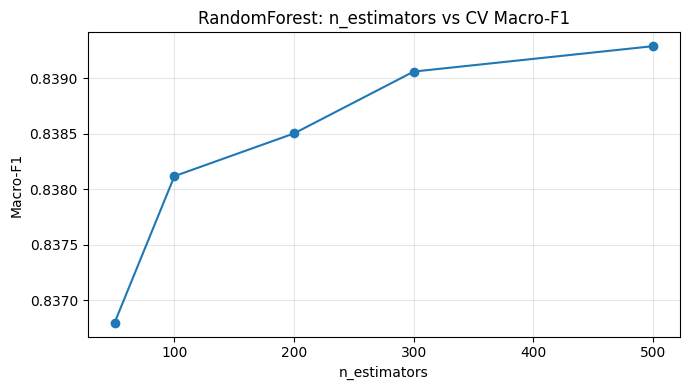

In [6]:
plt.figure(figsize=(7,4))
plt.plot(n_list, scores_mean, marker="o")
plt.title("RandomForest: n_estimators vs CV Macro-F1")
plt.xlabel("n_estimators")
plt.ylabel("Macro-F1")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۵) معیار ارزیابی: Macro F1-Score
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
با توجه به اینکه معیار داوری این تمرین <code>F1-Score</code> است، ما نیز مدل را با همین معیار می‌سنجیم.  
از <b>Macro-F1</b> استفاده می‌کنیم تا هر کلاس وزن برابر داشته باشد و مدل فقط روی کلاس غالب خوب عمل نکند.
</font>
</p>


In [7]:
depth_list = [None, 5, 10, 15, 20, 30]
scores_mean = []

for d in depth_list:
    rf = RandomForestClassifier(
        n_estimators=best_n,
        max_depth=d,
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring=f1_macro)
    scores_mean.append(scores.mean())
    print(f"max_depth={d}  => CV Macro-F1: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_depth = depth_list[int(np.argmax(scores_mean))]
print("\nBest max_depth:", best_depth)


max_depth=None  => CV Macro-F1: 0.8393 (+/- 0.0030)
max_depth=5  => CV Macro-F1: 0.7761 (+/- 0.0031)
max_depth=10  => CV Macro-F1: 0.8045 (+/- 0.0026)
max_depth=15  => CV Macro-F1: 0.8331 (+/- 0.0022)
max_depth=20  => CV Macro-F1: 0.8441 (+/- 0.0026)
max_depth=30  => CV Macro-F1: 0.8396 (+/- 0.0028)

Best max_depth: 20


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۶) تنظیم پارامترهای Random Forest با Cross-Validation
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
برای اینکه به بهترین عملکرد برسیم، فقط یک بار مدل را آموزش نمی‌دهیم؛  
بلکه پارامترهای مهم Random Forest را تست می‌کنیم، مثل:
<br>
- <code>n_estimators</code>: تعداد درخت‌ها (معمولاً هرچه بیشتر، پایدارتر ولی کندتر)
<br>
- <code>max_depth</code>: عمق درخت‌ها (کنترل overfitting/underfitting)
<br>
- <code>min_samples_split</code> و <code>min_samples_leaf</code>: جلوگیری از ساخت برگ‌های خیلی کوچک
<br>
- <code>max_features</code>: تعداد ویژگی‌هایی که هر درخت در هر split بررسی می‌کند
<br><br>
برای ارزیابی منصفانه و پایدار از <b>Cross-Validation</b> استفاده می‌کنیم.
</font>
</p>


In [8]:
leaf_list  = [1, 2, 5, 10]
split_list = [2, 5, 10, 20]

results = []

for leaf in leaf_list:
    for split in split_list:
        rf = RandomForestClassifier(
            n_estimators=best_n,
            max_depth=best_depth,
            min_samples_leaf=leaf,
            min_samples_split=split,
            random_state=42,
            n_jobs=-1
        )
        scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring=f1_macro)
        results.append({
            "min_samples_leaf": leaf,
            "min_samples_split": split,
            "cv_mean_f1": scores.mean(),
            "cv_std_f1": scores.std()
        })

results_df = pd.DataFrame(results).sort_values("cv_mean_f1", ascending=False)
results_df.head(10)


,min_samples_leaf,min_samples_split,cv_mean_f1,cv_std_f1
0,1,2,0.844093,0.002595
1,1,5,0.841037,0.002105
4,2,2,0.836753,0.003065
5,2,5,0.836191,0.002388
2,1,10,0.835127,0.002454
6,2,10,0.831721,0.003047
3,1,20,0.826666,0.003259
7,2,20,0.823878,0.002489
8,5,2,0.823244,0.002758
9,5,5,0.823244,0.002758


In [9]:
best_row = results_df.iloc[0]
best_leaf  = int(best_row["min_samples_leaf"])
best_split = int(best_row["min_samples_split"])

print("Best leaf:", best_leaf, "Best split:", best_split, "Best CV F1:", best_row["cv_mean_f1"])


Best leaf: 1 Best split: 2 Best CV F1: 0.8440929381950492


<h2 align=right style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="#0099cc">
۷) آموزش بهترین مدل و ارزیابی روی Validation
</font>
</h2>

<p dir=rtl style="direction: rtl; text-align: justify; line-height:200%; font-family:vazir; font-size:medium">
<font face="vazir" size=3>
پس از پیدا کردن بهترین پارامترها، مدل نهایی را با همان تنظیمات آموزش می‌دهیم و روی داده Validation ارزیابی می‌کنیم.  
علاوه بر F1-Score، ماتریس درهم‌ریختگی و گزارش طبقه‌بندی را نیز نمایش می‌دهیم تا نوع خطاهای مدل مشخص شود.
</font>
</p>


In [10]:
max_features_list = ["sqrt", "log2", None]
scores_mean = []

for mf in max_features_list:
    rf = RandomForestClassifier(
        n_estimators=best_n,
        max_depth=best_depth,
        min_samples_leaf=best_leaf,
        min_samples_split=best_split,
        max_features=mf,
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(rf, X_train, y_train, cv=cv, scoring=f1_macro)
    scores_mean.append(scores.mean())
    print(f"max_features={mf}  => CV Macro-F1: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_mf = max_features_list[int(np.argmax(scores_mean))]
print("\nBest max_features:", best_mf)


max_features=sqrt  => CV Macro-F1: 0.8441 (+/- 0.0026)
max_features=log2  => CV Macro-F1: 0.8441 (+/- 0.0026)
max_features=None  => CV Macro-F1: 0.8450 (+/- 0.0040)

Best max_features: None


In [13]:
import seaborn as sns

best_rf = RandomForestClassifier(
    n_estimators=best_n,
    max_depth=best_depth,
    min_samples_leaf=best_leaf,
    min_samples_split=best_split,
    max_features=best_mf,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_val)

print("=== Classification Report ===\n")
print(classification_report(y_val, y_pred))

print(f"\nMacro F1-Score: {f1_score(y_val, y_pred, average='macro'):.4f}")

cm = confusion_matrix(y_val, y_pred)
labels = sorted(y_val.unique())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Best Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'seaborn'